In [2]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# added to be able to run in Google Colab
import sys
sys.path.append('/content/gdrive/MyDrive/UTRECHT/utils')
sys.path.insert(0,'/content/gdrive/MyDrive/UTRECHT')

sys.path.append('/content/gdrive/MyDrive/UTRECHT/utils_clsWB')

import utils
import utils_clsWB

In [13]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from skimage import data, img_as_float
import pandas as pd
import sklearn.metrics
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
# import torch.nn.functional as F
import torchvision.transforms.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

from utils.flow_functions import *
from utils.dataset_padding4cls import *
from utils.network_arch_cls import *
# from utils.trainval_cls_withMasking import *
from utils.trainval_cls_withMasking_WB import *

from utils_clsWB.eval_funcs import *
from utils_clsWB.dataset_CIFAR100LT import *
from utils_clsWB.network_arch_resnet import *
# from utils_clsWB.trainval import *
from utils_clsWB.plot_funcs import *
from utils_clsWB.regularizers import *
from utils_clsWB.class_balanced_loss import CB_loss

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
2.0.0+cu118


#Setup config parameters
There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [5]:
# Here define the path, which is used to save the log and trained model in training process

cls_dir = '/content/gdrive/MyDrive/ENSO_project/03_cls'
trials = ['Trial_01']

# cpu or cuda
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:0'
print(device)

freqShow = 100

#model parameters
batch_size = 4
newSize = [512, 512]
total_epoch_num = 150    #300  # total number of epoch in training
base_lr = 0.0001      # base learning rate/


exp_dir = os.path.join(cls_dir, 'exp', trials[0]) # experiment directory, used for reading the init model
save_dir = exp_dir  # where to save the log file and trained models.

cuda:0


In [6]:
class PollenCls(Dataset):
    def __init__(self, dbinfo, size=[400, 400], set_name='train', maskType='pred'):
        if set_name=='val':
            set_name = 'test'
        self.set_name = set_name
        self.imageList = dbinfo[set_name+'_cls_imgList']
        
        if maskType=='pred':
            self.segList = dbinfo[set_name+'_cls_predMaskList']
        else:
            self.segList = dbinfo[set_name+'_cls_grndMaskList']
        
        # self.clsIDList = dbinfo[set_name+'_cls_classID']
        if set_name == 'train':
            self.clsIDList = dbinfo['train_kway_cls_classID']
        else: 
            self.clsIDList = dbinfo['test_kway_cls_classID']

        if set_name == 'train':
            self.clsNameList = dbinfo['train_cls_className']
        else: 
            self.clsNameList = dbinfo['test_cls_className']


        self.transform = transform                
        # self.size = size
        
        self.TFNormalize = transforms.Normalize([0.5] * 27, [0.5]*27)
        self.current_set_len = len(self.imageList)
        
        self.TF2tensor = transforms.ToTensor()
        self.TF2PIL = transforms.ToPILImage()
        # self.TFresize = transforms.Resize((self.size[0],self.size[1]))
        self.Pad = SquarePad()
        
    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):
        curImageName = self.imageList[idx]
        curMaskName = self.segList[idx]
        curLabelIndex = self.clsIDList[idx]   #.astype(np.float32)-1
        curLabelIndex = np.array([curLabelIndex]).astype(np.float32)
        class_name = self.clsNameList[idx]

        stack = []
        for file in sorted(os.listdir(curImageName)):
          if file.endswith('.png'):
            im_slice = Image.open(os.path.join(curImageName, file))
            im_slice = self.Pad(im_slice)
            stack.append(np.asarray(im_slice))
            image = np.block(stack)
            if image.shape[2] <27:
              pad_val = 27-image.shape[2]
              npad = ((0, 0), (0,0), (0,pad_val))
              image= np.pad(image, pad_width=npad, mode='constant', constant_values=0)

        # image = PIL.Image.open(curImageName)
        # image = self.Pad(image)
        segMask = Image.open(curMaskName)
        segMask = self.Pad(segMask)
        
        # if self.set_name=='train' and np.random.random(1)>0.5:
        #     image = image.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        #     segMask = segMask.transpose(PIL.Image.FLIP_LEFT_RIGHT)
            
        # image = np.array(image)
        segMask = np.array(segMask).astype(np.float32)
        segMask = segMask//255
        times = np.random.randint(4)
        image = np.rot90(image, times).copy()
        segMask = np.rot90(segMask, times).copy()
        
        #print('rot90 ', image.max(), image.min())
        
        image = self.TF2tensor(image)
        #print('to tensor ', image.max(), image.min())
        
        image = self.TFNormalize(image)
        #print('normalize ', image.max(), image.min())
        
        segMask = torch.from_numpy(segMask).unsqueeze(0) # self.TF2tensor(mask_overlap)                
        label = torch.from_numpy(curLabelIndex).unsqueeze(0).unsqueeze(0).unsqueeze(0)
        
        image = image.unsqueeze(0)
        # segMask = segMask.unsqueeze(0)        
        
        #print(image.shape, segMask.shape)
        # image = F.interpolate(image, size=(self.size[0],self.size[1]), mode='bilinear', align_corners=True)
        # segMask = F.interpolate(segMask, size=(self.size[0], self.size[1]), mode='nearest')
        image = image.squeeze(0)        
        label = label.squeeze(0)
        return image, segMask, label

In [7]:
with open(os.path.join(exp_dir, 'dbinfo.pkl'), 'rb') as handle:
    dbinfo = pickle.load(handle)

cls_datasets = {set_name: PollenCls(dbinfo, size=newSize, set_name=set_name, maskType='pred')
                for set_name in ['train', 'test']}


dataloaders = {set_name: DataLoader(cls_datasets[set_name],                                    
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=4) # num_work can be set to batch_size
               for set_name in ['train', 'test']}

print(len(cls_datasets['train']), len(cls_datasets['test']))

2614 633


In [14]:
print(dbinfo.keys())

dict_keys(['perClassCount', 'train_cls_imgList', 'train_cls_grndMaskList', 'train_cls_predMaskList', 'train_cls_className', 'train_kway_cls_classID', 'test_cls_imgList', 'test_cls_grndMaskList', 'test_cls_predMaskList', 'test_cls_className', 'test_kway_cls_classID', 'species_codes_dict'])


In [8]:
data_sampler = iter(dataloaders['test'])

In [9]:
data = next(data_sampler)
image, segMask, label = data

# Class name labels debugging

In [13]:
print(dbinfo.keys())

dict_keys(['perClassCount', 'train_cls_imgList', 'train_cls_grndMaskList', 'train_cls_predMaskList', 'train_cls_className', 'train_cls_classID', 'train_kway_cls_classID', 'test_cls_imgList', 'test_cls_grndMaskList', 'test_cls_predMaskList', 'test_cls_className', 'test_cls_classID', 'test_kway_cls_classID', 'species_codes_dict'])


In [17]:
train_kway_cls_classID = dbinfo['train_kway_cls_classID']
train_kway_cls_classID = set(train_kway_cls_classID)

print(len(train_cls_classID))

0


In [15]:
test_cls_classID = dbinfo['test_cls_classID']
test_cls_classID = set(test_cls_classID)

print(len(test_cls_classID))

0


In [16]:
species_codes_dict = dbinfo['species_codes_dict']
print(dbinfo['species_codes_dict'])

{'aln': 0, 'hup': 1, 'lyc': 2, 'ply': 3, 'poa': 4, 'pod': 5, 'Other': 6, 'False_det': 7}


In [ ]:
inv_species_codes_dict = {}
for key, val in species_codes_dict.items():
    inv_species_codes_dict[val] = key

print(inv_species_codes_dict)

{0: 'a/c', 1: 'aca', 2: 'alc', 3: 'alj', 4: 'aln', 5: 'amb', 6: 'ana', 7: 'api', 8: 'apo', 9: 'asl', 10: 'asr', 11: 'ast', 12: 'bor', 13: 'bot', 14: 'bra', 15: 'car', 16: 'che', 17: 'cle', 18: 'clo', 19: 'clu', 20: 'cur', 21: 'cyp', 22: 'dod', 23: 'dra', 24: 'eri', 25: 'fab', 26: 'gen', 27: 'gra', 28: 'gun', 29: 'hed', 30: 'hup', 31: 'hyd', 32: 'hyp', 33: 'iso', 34: 'jug', 35: 'lor', 36: 'lup', 37: 'lyc', 38: 'lys', 39: 'mel', 40: 'mol', 41: 'mon', 42: 'mrs', 43: 'myr', 44: 'pla', 45: 'ply', 46: 'poa', 47: 'pod', 48: 'pol', 49: 'rap', 50: 'rub', 51: 'rum', 52: 'run', 53: 'rut', 54: 'sal', 55: 'spo', 56: 'sty', 57: 'sym', 58: 'typ', 59: 'u/m', 60: 'u1', 61: 'u10', 62: 'u13', 63: 'u15', 64: 'u18', 65: 'u20', 66: 'u3', 67: 'u31', 68: 'u36', 69: 'u39', 70: 'u40', 71: 'u5', 72: 'u7', 73: 'u9', 74: 'val', 75: 'vla', 76: 'wei', 77: 'False_det'}


In [ ]:
classes = list(species_codes_dict.keys())
print(classes)

['a/c', 'aca', 'alc', 'alj', 'aln', 'amb', 'ana', 'api', 'apo', 'asl', 'asr', 'ast', 'bor', 'bot', 'bra', 'car', 'che', 'cle', 'clo', 'clu', 'cur', 'cyp', 'dod', 'dra', 'eri', 'fab', 'gen', 'gra', 'gun', 'hed', 'hup', 'hyd', 'hyp', 'iso', 'jug', 'lor', 'lup', 'lyc', 'lys', 'mel', 'mol', 'mon', 'mrs', 'myr', 'pla', 'ply', 'poa', 'pod', 'pol', 'rap', 'rub', 'rum', 'run', 'rut', 'sal', 'spo', 'sty', 'sym', 'typ', 'u/m', 'u1', 'u10', 'u13', 'u15', 'u18', 'u20', 'u3', 'u31', 'u36', 'u39', 'u40', 'u5', 'u7', 'u9', 'val', 'vla', 'wei', 'False_det']


In [ ]:
perClassCount_dict = {}

for i in range(len(classes)):
    className = classes[i]
    classCount = dbinfo['perClassCount'][i]
    if classCount != 0:
        perClassCount_dict.update({classes[i]:dbinfo['perClassCount'][i]})
print(perClassCount_dict)

{'aln': 174, 'ast': 77, 'cyp': 88, 'hed': 75, 'hup': 181, 'iso': 615, 'lyc': 394, 'mol': 68, 'pla': 60, 'poa': 603, 'u/m': 71, 'False_det': 118}


In [ ]:
perClassCount_dict.values()

dict_values([174, 77, 88, 75, 181, 615, 394, 68, 60, 603, 71, 118])

In [ ]:
perClassCount_dict_sorted = {k: v for k, v in sorted(perClassCount_dict.items(), reverse = True, key=lambda x: x[1])}
print(perClassCount_dict_sorted)

{'iso': 615, 'poa': 603, 'lyc': 394, 'hup': 181, 'aln': 174, 'False_det': 118, 'cyp': 88, 'ast': 77, 'hed': 75, 'u/m': 71, 'mol': 68, 'pla': 60}


In [ ]:
new_perClassCount = list(perClassCount_dict_sorted.values())
new_classes = list(perClassCount_dict_sorted.keys())
print(new_perClassCount)
print(new_classes)

[615, 603, 394, 181, 174, 118, 88, 77, 75, 71, 68, 60]
['iso', 'poa', 'lyc', 'hup', 'aln', 'False_det', 'cyp', 'ast', 'hed', 'u/m', 'mol', 'pla']


In [ ]:
new_species_code_dict = {}
old_to_new_code_dict = {}
for i, key in enumerate(perClassCount_dict_sorted.keys()):
    oldID = species_codes_dict[key]
    newID = i
    new_species_code_dict.update({key:i})
    old_to_new_code_dict.update({species_codes_dict[key]:i})

new_inv_species_codes_dict = {}
for key, val in new_species_code_dict.items():
    new_inv_species_codes_dict[val] = key

print(new_inv_species_codes_dict)

print(new_species_code_dict)
print(old_to_new_code_dict)

{0: 'iso', 1: 'poa', 2: 'lyc', 3: 'hup', 4: 'aln', 5: 'False_det', 6: 'cyp', 7: 'ast', 8: 'hed', 9: 'u/m', 10: 'mol', 11: 'pla'}
{'iso': 0, 'poa': 1, 'lyc': 2, 'hup': 3, 'aln': 4, 'False_det': 5, 'cyp': 6, 'ast': 7, 'hed': 8, 'u/m': 9, 'mol': 10, 'pla': 11}
{33: 0, 46: 1, 37: 2, 30: 3, 4: 4, 77: 5, 21: 6, 11: 7, 29: 8, 59: 9, 40: 10, 44: 11}


In [ ]:
set_name = 'train'
print(dbinfo[set_name+'_cls_classID'])

[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,

In [ ]:
train_new_cls_classID = []
test_new_cls_classID = []

for set_name in ['train','test']:
    if set_name == 'train':
        for oldID in dbinfo[set_name+'_cls_classID']:
          newID = float(old_to_new_code_dict[oldID])
          train_new_cls_classID.append(newID)

    if set_name == 'test':
        for oldID in dbinfo[set_name+'_cls_classID']:
          newID = float(old_to_new_code_dict[oldID])
          test_new_cls_classID.append(newID)

print(len(train_new_cls_classID), len(test_new_cls_classID))
print(train_new_cls_classID)

2035 489
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 

In [ ]:
sorted_classes = list(perClassCount_dict_sorted.keys())

In [85]:
class PollenCls(Dataset):
    def __init__(self, dbinfo, size=[400, 400], set_name='train', maskType='pred'):
        if set_name=='val':
            set_name = 'test'
        self.set_name = set_name
        self.imageList = dbinfo[set_name+'_cls_imgList']
        
        if maskType=='pred':
            self.segList = dbinfo[set_name+'_cls_predMaskList']
        else:
            self.segList = dbinfo[set_name+'_cls_grndMaskList']
        
        # self.clsIDList = dbinfo[set_name+'_cls_classID']
        if set_name == 'train':
            self.clsIDList = dbinfo['train_kway_cls_classID']
        else: 
            self.clsIDList = dbinfo['test_kway_cls_classID']

        if set_name == 'train':
            self.clsNameList = dbinfo['train_cls_className']
        else: 
            self.clsNameList = dbinfo['test_cls_className']


        self.transform = transform                
        # self.size = size
        
        self.TFNormalize = transforms.Normalize([0.5] * 27, [0.5]*27)
        self.current_set_len = len(self.imageList)
        
        self.TF2tensor = transforms.ToTensor()
        self.TF2PIL = transforms.ToPILImage()
        # self.TFresize = transforms.Resize((self.size[0],self.size[1]))
        self.Pad = SquarePad()
        
    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):
        curImageName = self.imageList[idx]
        curMaskName = self.segList[idx]
        curLabelIndex = self.clsIDList[idx]   #.astype(np.float32)-1
        curLabelIndex = np.array([curLabelIndex]).astype(np.float32)
        class_name = self.clsNameList[idx]

        stack = []
        for file in sorted(os.listdir(curImageName)):
          if file.endswith('.png'):
            im_slice = Image.open(os.path.join(curImageName, file))
            im_slice = self.Pad(im_slice)
            stack.append(np.asarray(im_slice))
            image = np.block(stack)
            if image.shape[2] <27:
              pad_val = 27-image.shape[2]
              npad = ((0, 0), (0,0), (0,pad_val))
              image= np.pad(image, pad_width=npad, mode='constant', constant_values=0)

        # image = PIL.Image.open(curImageName)
        # image = self.Pad(image)
        segMask = PIL.Image.open(curMaskName)
        segMask = self.Pad(segMask)
        
        # if self.set_name=='train' and np.random.random(1)>0.5:
        #     image = image.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        #     segMask = segMask.transpose(PIL.Image.FLIP_LEFT_RIGHT)
            
        # image = np.array(image)
        segMask = np.array(segMask).astype(np.float32)
        segMask = segMask//255
        times = np.random.randint(4)
        image = np.rot90(image, times).copy()
        segMask = np.rot90(segMask, times).copy()
        
        #print('rot90 ', image.max(), image.min())
        
        image = self.TF2tensor(image)
        #print('to tensor ', image.max(), image.min())
        
        image = self.TFNormalize(image)
        #print('normalize ', image.max(), image.min())
        
        segMask = torch.from_numpy(segMask).unsqueeze(0) # self.TF2tensor(mask_overlap)                
        label = torch.from_numpy(curLabelIndex).unsqueeze(0).unsqueeze(0).unsqueeze(0)
        
        image = image.unsqueeze(0)
        # segMask = segMask.unsqueeze(0)        
        
        #print(image.shape, segMask.shape)
        # image = F.interpolate(image, size=(self.size[0],self.size[1]), mode='bilinear', align_corners=True)
        # segMask = F.interpolate(segMask, size=(self.size[0], self.size[1]), mode='nearest')
        image = image.squeeze(0)        
        label = label.squeeze(0)
        return image, segMask, label

In [86]:
# with open(os.path.join(exp_dir, 'dbinfo.pkl'), 'rb') as handle:
#     dbinfo = pickle.load(handle)

cls_datasets = {set_name: PollenCls(dbinfo, size=newSize, set_name=set_name, maskType='pred')
                for set_name in ['train', 'test']}


dataloaders = {set_name: DataLoader(cls_datasets[set_name],                                    
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=4) # num_work can be set to batch_size
               for set_name in ['train', 'test']}

print(len(cls_datasets['train']), len(cls_datasets['test']))

2614 633


In [87]:
data_sampler = iter(dataloaders['test'])

In [90]:
data = next(data_sampler)
image, segMask, label = data

# Check dataset

Text(0.5, 1.0, 'seg mask')

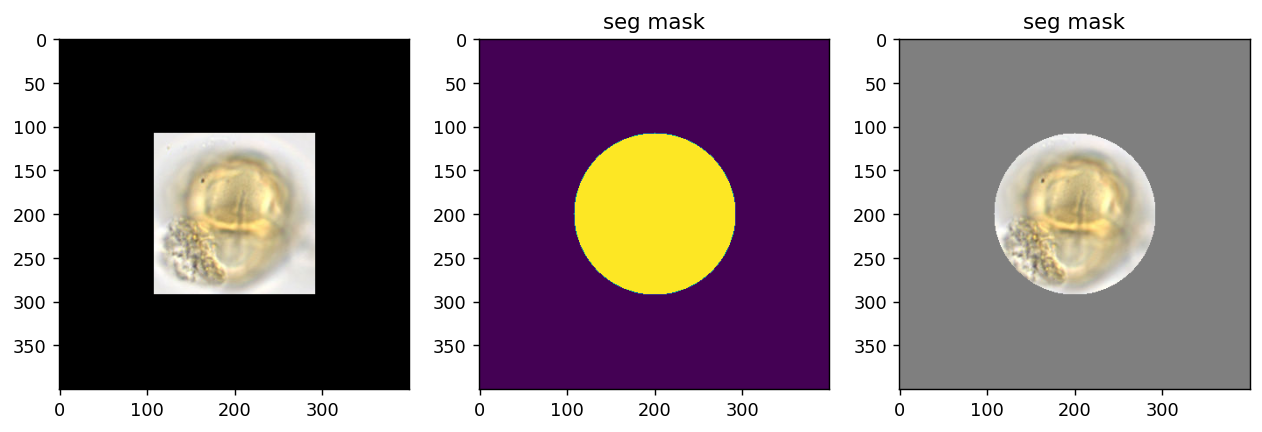

In [10]:
idx = 2
tmplabel = label[idx].squeeze().cpu().detach().numpy()
tmplabel = str(round(tmplabel.item()))
# tmpclass_name = str(class_name[idx])

numSample2Show = 1
figWinNumHeight, figWinNumWidth = 1, 3
plt.figure(figsize=(12, 4), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = image[idx].squeeze().cpu().detach().numpy().transpose((1,2,0))
tmpImg = tmpImg[:,:,0:3]
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
# plt.title(tmpclass_name)


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = segMask[idx].squeeze().cpu().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('seg mask')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = image[idx] * segMask[idx]
tmpImg = tmpImg.squeeze().cpu().detach().numpy().transpose((1,2,0))
tmpImg = (tmpImg+1)/2
tmpImg = tmpImg[:,:,0:3]
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('seg mask')

In [18]:
list(dbinfo['species_codes_dict'].keys())

['aln', 'hup', 'lyc', 'ply', 'poa', 'pod', 'Other', 'False_det']

In [11]:
# print(max(dbinfo['perClassCount']), min(dbinfo['perClassCount']))

Text(0, 0.5, 'number in train set')

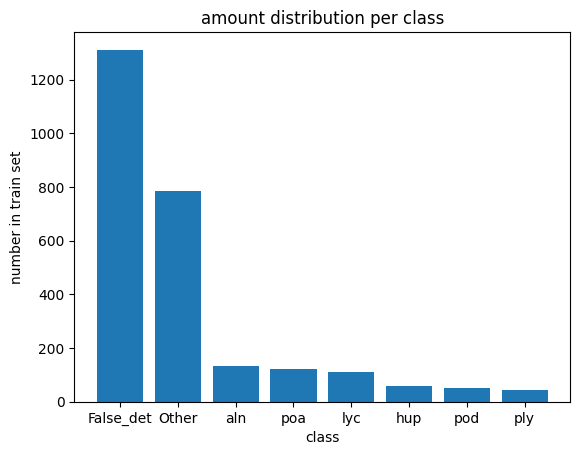

In [30]:
set_name = 'train'
df = pd.DataFrame(
   dict(
      cls_names=list(dbinfo['species_codes_dict'].keys()),
      counts = dbinfo['perClassCount'],
   )
)

df_sorted = df.sort_values('counts', ascending = False)
plt.bar('cls_names', 'counts', data = df_sorted)
plt.title('amount distribution per class')
plt.xlabel('class')
plt.ylabel('number in train set')
# print(min(dbinfo[set_name + '_cls_classID']), max(dbinfo[set_name + '_cls_classID']))

In [22]:
resnet = models.resnet18(pretrained=True)
resnet = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 275MB/s]
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 166MB/s]


In [23]:
################## init model ###################
initModel = PollenClsNet(34, nClass=12, pretrained=True, poolSize=16)
initModel.encoder.encoder.conv1 = nn.Conv2d(27, 64, (7, 7), (2, 2), (3, 3), bias=False) #change dimensions of the first layer in the encoder
initModel.pool = nn.MaxPool2d(13, stride=13)
initModel.to(device);

using pretrained model


In [24]:
image = image.to(device)
label = label.type(torch.long).view(-1).to(device)
outputs = initModel(image)

# Training with weight decay 0.0005

In [25]:
model_name = 'with_WD_model_0.0005'
weight_decay=0.0005
log_filename = os.path.join(save_dir, model_name+'_train.log')

In [26]:
lossFunc_cls = nn.CrossEntropyLoss()
loss = lossFunc_cls(outputs, label.squeeze(-1).squeeze(-1))

In [27]:
optimizer = optim.SGD([{'params': initModel.parameters(), 'lr': base_lr}], lr=base_lr, momentum=0.9, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, total_epoch_num, eta_min=0)

In [ ]:
# load a checkpoint
# baseModel_dir = save_dir
# checkpoint = torch.load(path.join(baseModel_dir, 'bestValModel.pt'))
# checkpoint = torch.load(path.join(baseModel_dir, 'epoch-60.pt'))


checkpoint = torch.load('/content/gdrive/MyDrive/UTRECHT/Class/exp/clsPredMaskPadNoInd_resnet_ShuWeights_2022_06_15/with_WD_model_0005_K-Way_12class_NoMask_best.paramOnly')
initModel.load_state_dict(checkpoint['model'])
epoch = 0
initModel.to(device) 
initModel.train();

In [18]:
# ################## start training ###################
fn = open(log_filename,'w')
fn.write(log_filename+'\t'+device+'\n\n')
#fn.write(path.basename(__file__)+'\n\n')
fn.close()
file_to_note_bestModel = os.path.join(save_dir, model_name+'_note_bestModel.log')
fn = open(file_to_note_bestModel, 'w')
fn.write('Record of best models on the way.\n')
fn.close()

In [19]:
model_ft, trackRecords = train_model(initModel, dataloaders, lossFunc_cls,
                optimizer, scheduler, num_epochs=total_epoch_num,
                model_name= model_name, pgdFunc=None, nClasses = 8, work_dir=save_dir, device=device)


Epoch 1/150
----------
train
	loss:1.964696, acc-all:0.48470, acc-avg-cls:0.16462
test
	loss:1.620306, acc-all:0.48657, acc-avg-cls:0.15026

Epoch 2/150
----------
train
	loss:1.363934, acc-all:0.54935, acc-avg-cls:0.21562
test
	loss:1.174857, acc-all:0.60190, acc-avg-cls:0.27602

Epoch 3/150
----------
train
	loss:1.220849, acc-all:0.59334, acc-avg-cls:0.27584
test
	loss:1.229996, acc-all:0.59400, acc-avg-cls:0.35510

Epoch 4/150
----------
train
	loss:1.148011, acc-all:0.60903, acc-avg-cls:0.31437
test
	loss:1.197354, acc-all:0.62243, acc-avg-cls:0.27749

Epoch 5/150
----------
train
	loss:1.096070, acc-all:0.62433, acc-avg-cls:0.33014
test
	loss:1.175543, acc-all:0.61137, acc-avg-cls:0.25618

Epoch 6/150
----------
train
	loss:1.097250, acc-all:0.62127, acc-avg-cls:0.33089
test
	loss:1.229493, acc-all:0.60664, acc-avg-cls:0.33075

Epoch 7/150
----------
train
	loss:1.058407, acc-all:0.63925, acc-avg-cls:0.37247
test
	loss:1.125786, acc-all:0.59874, acc-avg-cls:0.29847

Epoch 8/150


OSError: ignored

In [1]:
model_name = 'with_WD_model_0.0005'
trackRecords_filename = os.path.join(save_dir, model_name + '_trackRecords.pkl')

# create a binary pickle file 
f = open(trackRecords_filename,"wb")

# write the python object (dict) to pickle file
pickle.dump(trackRecords,f)

# close file
f.close()

NameError: ignored

In [ ]:
model_name = 'with_WD_model_0.0005'
trackRecords_filename = os.path.join(save_dir, model_name + '_trackRecords.pkl')
with open(trackRecords_filename, 'rb') as handle:
    trackRecords_read = pickle.load(handle)

In [ ]:
max(trackRecords_read['acc_test'])

In [ ]:
models= {}
model_name = 'with_WD_model_0.0005'
# load model with best epoch accuracy
path_to_clsnet = os.path.join(save_dir, model_name+'_best.paramOnly')
initModel.load_state_dict(torch.load(path_to_clsnet, map_location=device));

initModel.to(device);
initModel.eval();
models['with_WD_model_0.0005'] = initModel

In [ ]:
print(models.keys())

In [ ]:
print(dbinfo['train_cls_classID'])

In [ ]:
a = print_accuracy(initModel, dataloaders, np.array(train_new_cls_classID), device = device, nClasses = 12)

acc avgClass:  67.4%
Many: 88.4% Medium: 52.3% Few: 0.0%


TypeError: ignored

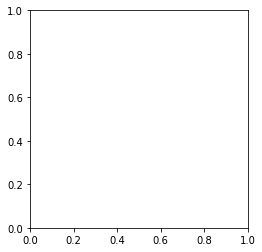

In [ ]:
plt.imshow(a, cmap='hot', interpolation='nearest')

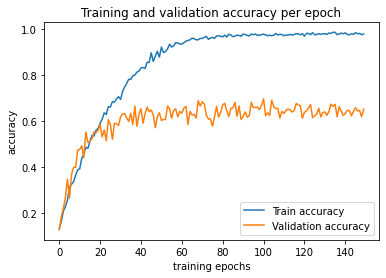

In [ ]:
plot_per_epoch_accuracy(trackRecords_read)

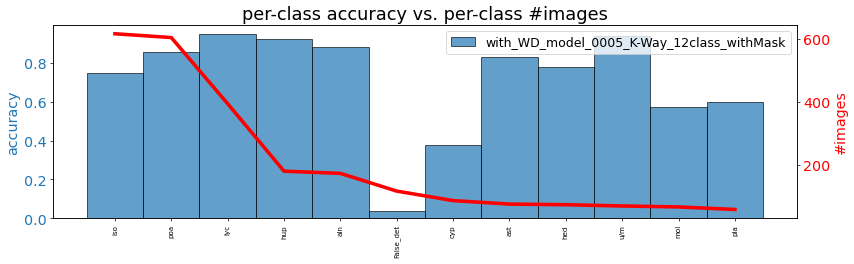

In [ ]:
plot_per_class_accuracy(models, dataloaders, new_classes, new_perClassCount, nClasses=12, device = device)
# plt.savefig(os.path.join(save_dir,'plot_per_class_accuracy_naive_vs_WD.png'), format='png', dpi = 300)

In [ ]:
plot_norms(models['with_WD_model_0005_K-Way_12class_withMask'], classes)

# Training with weight decay trial 0.001

In [ ]:
model_name = 'with_WD_model_001_K-Way'
weight_decay=0.001
log_filename = os.path.join(save_dir, model_name+'_train.log')

In [ ]:
lossFunc_cls = nn.CrossEntropyLoss()
loss = lossFunc_cls(outputs, label.squeeze(-1).squeeze(-1))

In [ ]:
optimizer = optim.SGD([{'params': initModel.parameters(), 'lr': base_lr}], lr=base_lr, momentum=0.9, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, total_epoch_num, eta_min=0)

In [ ]:
# ################## start training ###################
fn = open(log_filename,'w')
fn.write(log_filename+'\t'+device+'\n\n')
#fn.write(path.basename(__file__)+'\n\n')
fn.close()
file_to_note_bestModel = os.path.join(save_dir, model_name+'_note_bestModel.log')
fn = open(file_to_note_bestModel, 'w')
fn.write('Record of best models on the way.\n')
fn.close()

In [ ]:
model_ft, trackRecords = train_model(initModel, dataloaders, lossFunc_cls,
                optimizer, scheduler, num_epochs=total_epoch_num,
                model_name= model_name, pgdFunc=None, nClasses = 78, work_dir=save_dir, device=device)


Epoch 1/150
----------
train
	loss:3.351699, acc-all:0.27923, acc-avg-cls:0.03086
test
	loss:2.237068, acc-all:0.45053, acc-avg-cls:0.11191

Epoch 2/150
----------
train
	loss:2.585183, acc-all:0.38577, acc-avg-cls:0.05524
test
	loss:2.122162, acc-all:0.47703, acc-avg-cls:0.09360

Epoch 3/150
----------
train
	loss:2.180211, acc-all:0.45885, acc-avg-cls:0.07578
test
	loss:2.014134, acc-all:0.52827, acc-avg-cls:0.13521

Epoch 4/150
----------
train
	loss:1.957733, acc-all:0.49885, acc-avg-cls:0.08531
test
	loss:1.870548, acc-all:0.59717, acc-avg-cls:0.16755

Epoch 5/150
----------
train
	loss:1.818506, acc-all:0.53269, acc-avg-cls:0.11379
test
	loss:1.681999, acc-all:0.57774, acc-avg-cls:0.15773

Epoch 6/150
----------
train
	loss:1.680264, acc-all:0.55385, acc-avg-cls:0.11732
test
	loss:1.991583, acc-all:0.51590, acc-avg-cls:0.19373

Epoch 7/150
----------
train
	loss:1.586272, acc-all:0.57269, acc-avg-cls:0.13306
test
	loss:1.630054, acc-all:0.61484, acc-avg-cls:0.19439

Epoch 8/150


In [ ]:
model_name = 'with_WD_model_001_K-Way'
trackRecords_filename = os.path.join(save_dir, model_name + '_trackRecords.pkl')

# create a binary pickle file 
f = open(trackRecords_filename,"wb")

# write the python object (dict) to pickle file
pickle.dump(trackRecords,f)

# close file
f.close()

In [ ]:
model_name = 'with_WD_model_001_K-Way'
trackRecords_filename = os.path.join(save_dir, model_name + '_trackRecords.pkl')
with open(trackRecords_filename, 'rb') as handle:
    trackRecords_read = pickle.load(handle)

FileNotFoundError: ignored

In [ ]:
models= {}
model_name = 'with_WD_model_001_K-Way'
# load model with best epoch accuracy
path_to_clsnet = os.path.join(save_dir, model_name+'_best.paramOnly')
initModel.load_state_dict(torch.load(path_to_clsnet, map_location=device));

initModel.to(device);
initModel.eval();
models['with_WD_model_001_K-Way'] = initModel

In [ ]:
print(models.keys())

dict_keys(['with_WD_model_001_K-Way'])


In [ ]:
a = print_accuracy(initModel, dataloaders, np.array(dbinfo['train_cls_classID']), device = device, nClasses = 78)

acc avgClass:  20.7%
Many: 73.4% Medium: 41.3% Few: 7.1%


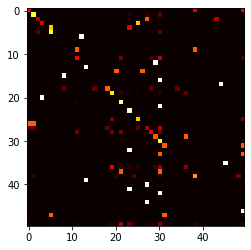

In [ ]:
plt.imshow(a, cmap='hot', interpolation='nearest')

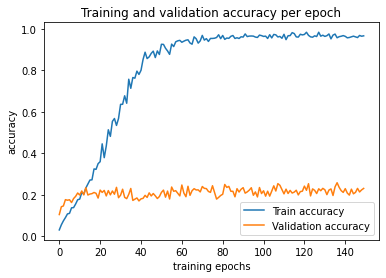

In [ ]:
plot_per_epoch_accuracy(trackRecords_read)

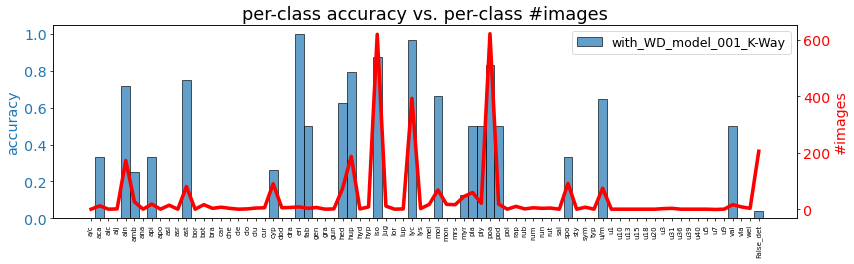

In [ ]:
plot_per_class_accuracy(models, dataloaders, classes, dbinfo['perClassCount'], nClasses=78, device = device)
# plt.savefig(os.path.join(save_dir,'plot_per_class_accuracy_naive_vs_WD.png'), format='png', dpi = 300)

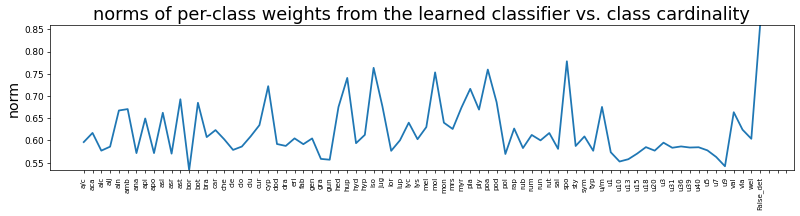

In [ ]:
plot_norms(models['with_WD_model_001_K-Way'], classes)

# Training with weight decay trial 0.0001

In [ ]:
model_name = 'with_WD_model_0001_K-Way'
weight_decay=0.0001
log_filename = os.path.join(save_dir, model_name+'_train.log')

In [ ]:
lossFunc_cls = nn.CrossEntropyLoss()
loss = lossFunc_cls(outputs, label.squeeze(-1).squeeze(-1))

In [ ]:
optimizer = optim.SGD([{'params': initModel.parameters(), 'lr': base_lr}], lr=base_lr, momentum=0.9, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, total_epoch_num, eta_min=0)

In [ ]:
# ################## start training ###################
fn = open(log_filename,'w')
fn.write(log_filename+'\t'+device+'\n\n')
#fn.write(path.basename(__file__)+'\n\n')
fn.close()
file_to_note_bestModel = os.path.join(save_dir, model_name+'_note_bestModel.log')
fn = open(file_to_note_bestModel, 'w')
fn.write('Record of best models on the way.\n')
fn.close()

In [ ]:
model_ft, trackRecords = train_model(initModel, dataloaders, lossFunc_cls,
                optimizer, scheduler, num_epochs=total_epoch_num,
                model_name= model_name, pgdFunc=None, nClasses = 78, work_dir=save_dir, device=device)


Epoch 1/150
----------
train
	loss:3.501883, acc-all:0.28308, acc-avg-cls:0.03156
test
	loss:2.809857, acc-all:0.38339, acc-avg-cls:0.08849

Epoch 2/150
----------
train
	loss:2.592451, acc-all:0.39692, acc-avg-cls:0.05467
test
	loss:2.295578, acc-all:0.45760, acc-avg-cls:0.09719

Epoch 3/150
----------
train
	loss:2.360740, acc-all:0.44115, acc-avg-cls:0.07214
test
	loss:2.700783, acc-all:0.42756, acc-avg-cls:0.11707

Epoch 4/150
----------
train
	loss:2.018239, acc-all:0.50308, acc-avg-cls:0.09234
test
	loss:2.055831, acc-all:0.56890, acc-avg-cls:0.13567

Epoch 5/150
----------
train
	loss:1.824590, acc-all:0.53462, acc-avg-cls:0.11058
test
	loss:1.702267, acc-all:0.59717, acc-avg-cls:0.14726

Epoch 6/150
----------
train
	loss:1.709230, acc-all:0.55462, acc-avg-cls:0.11972
test
	loss:1.826385, acc-all:0.55477, acc-avg-cls:0.14447

Epoch 7/150
----------
train
	loss:1.666359, acc-all:0.57346, acc-avg-cls:0.13213
test
	loss:1.659473, acc-all:0.61837, acc-avg-cls:0.17803

Epoch 8/150


In [ ]:
#model_name = 'with_WD_model_001_K-Way' #### made a mistake, overwrote 001. 
model_name = 'with_WD_model_0001_K-Way'

trackRecords_filename = os.path.join(save_dir, model_name + '_trackRecords.pkl')

# create a binary pickle file 
f = open(trackRecords_filename,"wb")

# write the python object (dict) to pickle file
pickle.dump(trackRecords,f)

# close file
f.close()

In [ ]:
model_name = 'with_WD_model_0001_K-Way'
trackRecords_filename = os.path.join(save_dir, model_name + '_trackRecords.pkl')
with open(trackRecords_filename, 'rb') as handle:
    trackRecords_read = pickle.load(handle)

In [ ]:
max(trackRecords_read['acc_test'])

0.2481615775296607

In [ ]:
models= {}
model_name = 'with_WD_model_0001_K-Way'
# load model with best epoch accuracy
path_to_clsnet = os.path.join(save_dir, model_name+'_best.paramOnly')
initModel.load_state_dict(torch.load(path_to_clsnet, map_location=device));

initModel.to(device);
initModel.eval();
models['with_WD_model_0001_K-Way'] = initModel

In [ ]:
a = print_accuracy(initModel, dataloaders, np.array(dbinfo['train_cls_classID']), device = device, nClasses = 78)

acc avgClass:  23.9%
Many: 73.0% Medium: 38.4% Few: 11.5%


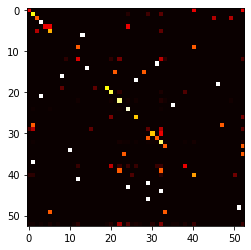

In [ ]:
plt.imshow(a, cmap='hot', interpolation='nearest')

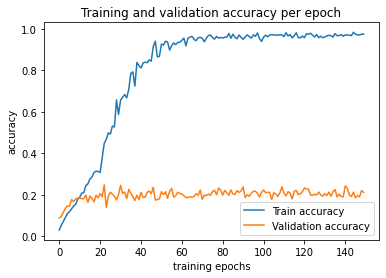

In [ ]:
plot_per_epoch_accuracy(trackRecords_read)

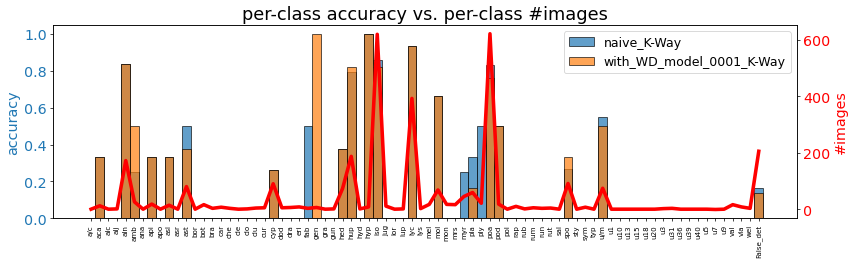

In [ ]:
plot_per_class_accuracy(models, dataloaders, classes, dbinfo['perClassCount'], nClasses=78, device = device)
# plt.savefig(os.path.join(save_dir,'plot_per_class_accuracy_naive_vs_WD.png'), format='png', dpi = 300)

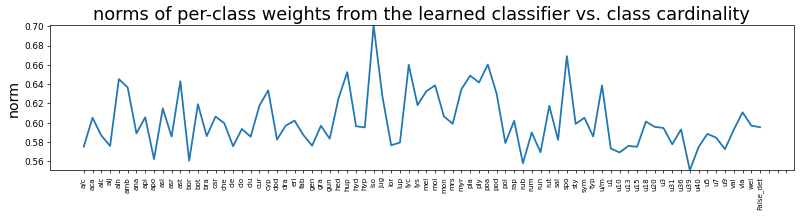

In [ ]:
plot_norms(models['with_WD_model_0001_K-Way'], classes)